B2_3_EM_20110110_134300_030400_AR11140 max 255
B2_3_EM_20110110_134300_AR11140 min 0
B2_3_INT_20110110_134300_030400_AR11140 max 255
B2_3_INT_20110110_134300_AR11140 min 0


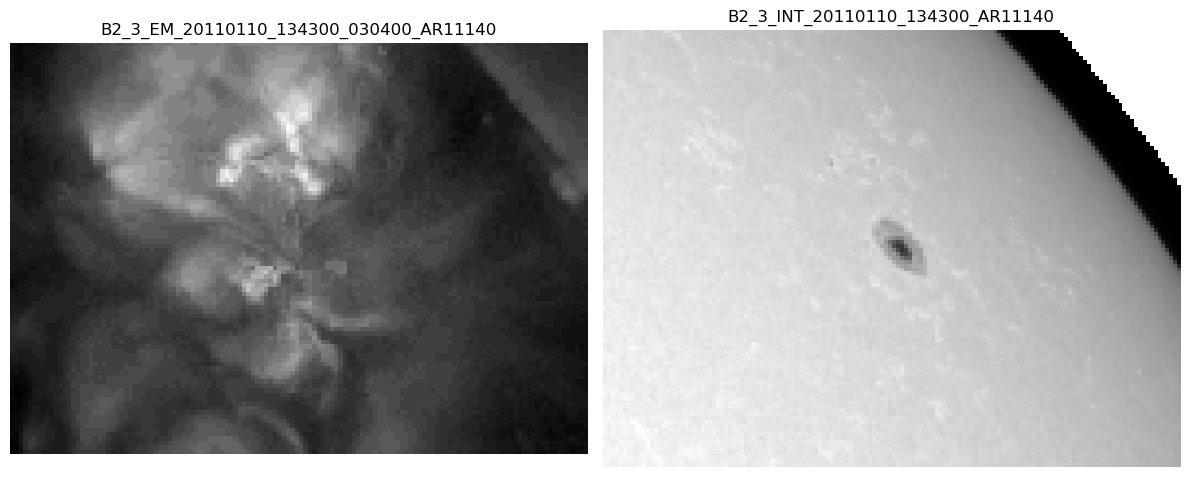

In [13]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.convert
# Load and convert images to grayscale
B2_3_EM = Image.open("20110110_030400_AR11140.png").convert("L")
B2_3_INT = Image.open("20110110_115810_AR11140.png").convert("L")

# Convert the images to NumPy arrays
B2_3_EM_20110110_134300_030400_AR11140 = np.array(B2_3_EM)
B2_3_INT_20110110_134300_AR11140 = np.array(B2_3_INT)

# Print min and max values for each image
print("B2_3_EM_20110110_134300_030400_AR11140 max", B2_3_EM_20110110_134300_AR11140.max())
print("B2_3_EM_20110110_134300_AR11140 min", B2_3_EM_20110110_134300_AR11140.min())

print("B2_3_INT_20110110_134300_030400_AR11140 max", B2_3_INT_20110110_134300_AR11140.max())
print("B2_3_INT_20110110_134300_AR11140 min", B2_3_INT_20110110_134300_AR11140.min())

# Create a figure with 1 row and 2 columns for the images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the first image with a title on top
axs[0].imshow(B2_3_EM_20110110_134300_030400_AR11140, cmap='gray')
axs[0].set_title("B2_3_EM_20110110_134300_030400_AR11140")
axs[0].axis('off')  # Turn off axis labels

# Display the second image with a title on top
axs[1].imshow(B2_3_INT_20110110_134300_AR11140, cmap='gray')
axs[1].set_title("B2_3_INT_20110110_134300_AR11140")
axs[1].axis('off')  # Turn off axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


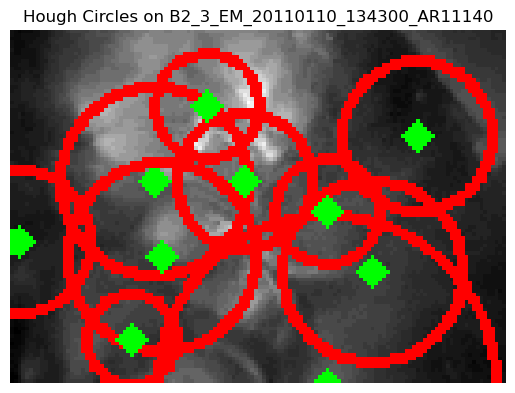

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assume B2_3_EM_20110110_134300_AR11140 is already defined as a NumPy array in grayscale.
# For example:
# B2_3_EM_20110110_134300_AR11140 = np.array(Image.open("20110110_030400_AR11140.png").convert("L"))

# https://docs.opencv.org/4.x/d3/de5/tutorial_js_houghcircles.html
circles = cv2.HoughCircles(B2_3_EM_20110110_134300_030400_AR11140, 
                           cv2.HOUGH_GRADIENT, 
                           dp=1, 
                           minDist=20,
                           param1=50, 
                           param2=30, 
                           minRadius=0, 
                           maxRadius=0)

# Convert grayscale image to BGR to draw colored circles
img_color = cv2.cvtColor(B2_3_EM_20110110_134300_AR11140, cv2.COLOR_GRAY2BGR)

# If some circles are detected, draw them
if circles is not None:
    # Round the circle parameters to integers
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        center = (circle[0], circle[1])
        radius = circle[2]
        # Draw the center of the circle in green
        cv2.circle(img_color, center, 2, (0, 255, 0), 3)
        # Draw the perimeter of the circle in red
        cv2.circle(img_color, center, radius, (0, 0, 255), 2)

# Convert BGR image to RGB for displaying with matplotlib
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

# Display the image with detected circles
plt.imshow(img_rgb)
plt.title("Hough Circles on B2_3_EM_20110110_134300_AR11140")
plt.axis("off")
plt.show()


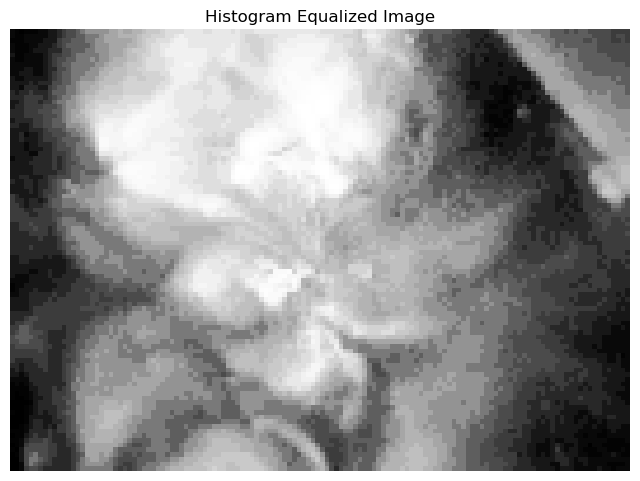

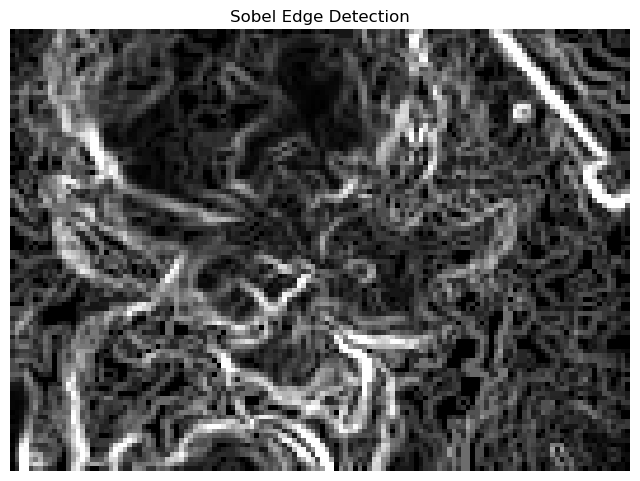

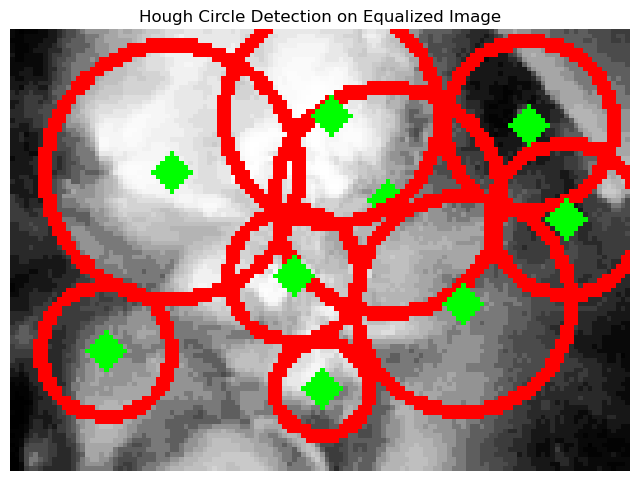

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the grayscale image
B2_3_EM = Image.open("20110110_030400_AR11140.png").convert("L")
B2_3_EM_20110110_134300_AR11140 = np.array(B2_3_EM)

# ----------------------------------
# 1. Histogram Equalization
# ----------------------------------
equalized = cv2.equalizeHist(B2_3_EM_20110110_134300_AR11140)

plt.figure(figsize=(8,6))
plt.imshow(equalized, cmap='gray')
plt.title("Histogram Equalized Image")
plt.axis('off')
plt.show()

# ----------------------------------
# 2. Sobel Edge Detection
# ----------------------------------
# Compute gradients in the x and y directions
sobelx = cv2.Sobel(equalized, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(equalized, cv2.CV_64F, 0, 1, ksize=3)
# Compute the gradient magnitude
sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
# Scale the values to 8-bit (0-255) for display purposes
sobel_magnitude = np.uint8(np.clip(sobel_magnitude, 0, 255))

plt.figure(figsize=(8,6))
plt.imshow(sobel_magnitude, cmap='gray')
plt.title("Sobel Edge Detection")
plt.axis('off')
plt.show()

# ----------------------------------
# 3. Hough Circle Detection
# ----------------------------------
# Apply a median blur to reduce noise before circle detection
blurred = cv2.medianBlur(equalized, 5)
circles = cv2.HoughCircles(blurred,
                           cv2.HOUGH_GRADIENT,
                           dp=1,
                           minDist=20,
                           param1=50,
                           param2=30,
                           minRadius=0,
                           maxRadius=0)

# Convert equalized image to BGR so we can draw colored circles
equalized_color = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        center = (circle[0], circle[1])
        radius = circle[2]
        # Draw the circle center in green
        cv2.circle(equalized_color, center, 2, (0, 255, 0), 3)
        # Draw the circle outline in red
        cv2.circle(equalized_color, center, radius, (0, 0, 255), 2)

# Convert BGR to RGB for displaying with matplotlib
equalized_rgb = cv2.cvtColor(equalized_color, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,6))
plt.imshow(equalized_rgb)
plt.title("Hough Circle Detection on Equalized Image")
plt.axis('off')
plt.show()
